### TSNE

In [46]:
%matplotlib ipympl

In [47]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib.gridspec import GridSpec

# ------------------ Data Loading Functions ------------------

def load_jsonl(file_path):
    embeddings = []
    levels = []
    with open(file_path, 'r') as f:
        for line in f:
            # Parse each line as JSON and append it to the list
            obj = json.loads(line)
            embeddings.append(obj['embedding'])
            levels.append(obj['level'])
    return embeddings, levels

In [48]:
import random
import itertools
# Load embeddings
all_embeddings = []
all_levels = []

files = os.listdir(os.path.abspath('../step_1_get_embedding_value/contexts'))
files = sorted(files, key=lambda x: int(x.split('.')[0].split('_')[-1]))

for file_name in files[:10]:
    embeddings_file_path = f"../step_1_get_embedding_value/contexts/{file_name}"
    print(embeddings_file_path)
    embeddings, levels = load_jsonl(embeddings_file_path)
    
    # Append to the combined lists
    all_embeddings.append(embeddings)
    all_levels.append(levels)

# Combine all_embeddings and all_levels into a single list of tuples for easy random selection
num_samples = 4
selected_indices = random.sample(range(len(all_embeddings)), num_samples)
print(selected_indices)

# Randomly select 4 tuples
selected_embeddings = [all_embeddings[i] for i in selected_indices]
selected_levels = [all_levels[i] for i in selected_indices]

selected_embeddings = list(itertools.chain.from_iterable(selected_embeddings))
selected_levels = list(itertools.chain.from_iterable(selected_levels))

../step_1_get_embedding_value/contexts/embeddings_gpt-4o-batch-all-target_1_parser_ManuallyHierarchicalNodeParser_7652_gpu_V100_nodeNum_50_pid_0.jsonl
../step_1_get_embedding_value/contexts/embeddings_gpt-4o-batch-all-target_1_parser_ManuallyHierarchicalNodeParser_7652_gpu_V100_nodeNum_50_pid_1.jsonl
../step_1_get_embedding_value/contexts/embeddings_gpt-4o-batch-all-target_1_parser_ManuallyHierarchicalNodeParser_7652_gpu_V100_nodeNum_50_pid_2.jsonl
../step_1_get_embedding_value/contexts/embeddings_gpt-4o-batch-all-target_1_parser_ManuallyHierarchicalNodeParser_7652_gpu_V100_nodeNum_50_pid_3.jsonl
../step_1_get_embedding_value/contexts/embeddings_gpt-4o-batch-all-target_1_parser_ManuallyHierarchicalNodeParser_7652_gpu_V100_nodeNum_50_pid_4.jsonl
../step_1_get_embedding_value/contexts/embeddings_gpt-4o-batch-all-target_1_parser_ManuallyHierarchicalNodeParser_7652_gpu_V100_nodeNum_50_pid_5.jsonl
../step_1_get_embedding_value/contexts/embeddings_gpt-4o-batch-all-target_1_parser_ManuallyHie

In [51]:
df_total = pd.DataFrame({
    'embeddings': [tuple(embedding) for embedding in selected_embeddings],
    'levels': selected_levels
})


### Check if the value are unique

In [52]:
def unique_values(filtered_df):
    # Count unique tsne values for each level
    doc_count = len(filtered_df[filtered_df['levels'] == 'document']['embeddings'].unique())
    section_count = len(filtered_df[filtered_df['levels'] == 'section']['embeddings'].unique())
    paragraph_count = len(filtered_df[filtered_df['levels'] == 'paragraph']['embeddings'].unique())
    multi_sent_count = len(filtered_df[filtered_df['levels'] == 'multi-sentences']['embeddings'].unique())

    # Print formatted results
    print(f"Document number of df: {len(filtered_df[filtered_df['levels'] == 'document'])}")
    print(f"Unique embeddings counts:")
    print(f"Document: {doc_count}")
    print(f"Section: {section_count}")
    print(f"Paragraph: {paragraph_count}")
    print(f"Multi-Sentences: {multi_sent_count}")
    
unique_values(df_total)

Document number of df: 200
Unique embeddings counts:
Document: 200
Section: 4121
Paragraph: 13542
Multi-Sentences: 29263


In [ ]:
import json

def unique_values(filtered_df, output_file):
    # Count unique tsne values for each level
    unique_embeddings = {
        'document': filtered_df[filtered_df['level'] == 'document']['embeddings'].unique().tolist(),
        'section': filtered_df[filtered_df['level'] == 'section']['embeddings'].unique().tolist(),
        'paragraph': filtered_df[filtered_df['level'] == 'paragraph']['embeddings'].unique().tolist(),
        'multi-sentences': filtered_df[filtered_df['level'] == 'multi-sentences']['embeddings'].unique().tolist(),
    }

    # Print formatted results
    print(f"Unique embeddings counts:")
    for level, embeddings in unique_embeddings.items():
        print(f"{level.capitalize()}: {len(embeddings)}")

    # Save unique embeddings to JSONL file
    with open(output_file, 'w') as f:
        for level, embeddings in unique_embeddings.items():
            for embedding in embeddings:
                json_record = {'level': level, 'embedding': embedding}
                f.write(json.dumps(json_record) + '\n')

# Usage
unique_values(df_total, 'unique_embeddings.jsonl')


### Generate TSNE results

In [61]:
# ------------------ TSNE and Data Preparation ------------------

def get_tsne_result(embeddings, n_components=2, perplexity=30, random_state=42):
    """Generate TSNE result from embeddings."""
    tsne = TSNE(n_components, perplexity=perplexity, random_state=random_state)
    tsne_result = tsne.fit_transform(embeddings)
    return tsne_result

def create_tsne_dataframe(tsne_result, levels):
    """Create a DataFrame with TSNE result and corresponding labels."""
    return pd.DataFrame({'tsne_1': tsne_result[:, 0], 'tsne_2': tsne_result[:, 1], 'label': levels})

# ------------------ Plotting Functions ------------------

def plot_tsne_result(tsne_result_df, unique_labels, palette, nodes_file_name): #nodes_file_name
    """Plot TSNE result using a scatter plot with subplots for individual labels."""
    # Create a figure and a GridSpec layout
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(2, 3, width_ratios=[2, 1, 1])

    # Create the large plot on the left (spanning both rows)
    ax_main = fig.add_subplot(gs[:, 0])
    sns.scatterplot(data=tsne_result_df, x='tsne_1', y='tsne_2', hue='label', palette=palette, ax=ax_main, alpha=0.5)
    ax_main.set_title('All Data')

    # Get x and y axis limits from the main plot
    xlim = ax_main.get_xlim()
    ylim = ax_main.get_ylim()

    # Create the 2x2 grid on the right for individual label plots
    for i, label in enumerate(unique_labels[:4]):
        ax = fig.add_subplot(gs[i // 2, i % 2 + 1])
        label_data = tsne_result_df[tsne_result_df['label'] == label]
        sns.scatterplot(data=label_data, x='tsne_1', y='tsne_2', color=palette[i], ax=ax, alpha=0.8)

        # Set x and y limits to match the main plot
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_title(f'Label {label}')
        ax.legend([label])

    # # Adjust layout and save the image
    # plt.tight_layout()
    
    # Enable interactive mode
    plt.ion()  # Use this in scripts to enable interactive mode
    plt.show()  # Show the plot
    plt.savefig(f"tsne_result_{nodes_file_name}.png")
    # plt.close()

In [54]:
# Generate TSNE result
tsne_results = []
embeddings = np.array(df_total['embeddings'].tolist())
levels = df_total['levels'].tolist()

In [55]:
random_states = [42] # , 300, 1001
perplexities = [10] # , 20, 30, 40, 50

In [56]:
# Generate tsne with different parameters
for random_state in random_states: # , 300, 1001
    print(f"random_state: {random_state}")
    tsne_one_row = []
    for perplexity in perplexities: # , 20, 30, 40, 50
        print(f"property: {perplexity}")
        tsne_one_row.append(get_tsne_result(embeddings, 2, perplexity, random_state))
    tsne_results.append(tsne_one_row)

random_state: 42
property: 10


In [57]:
def save_tsne_result():
    data_to_save = []

    # Iterate over the random_state and properties
    for i, random_state in enumerate(random_states): # , 300, 1001
        for j, property in enumerate(perplexities): # , 20, 30, 40, 50
            # Get the t-SNE results for this combination
            tsne_result = tsne_results[i][j]
            
            # For each embedding row, append the random_state, property, levels, and t-SNE coordinates
            for idx in range(len(levels)):
                data_to_save.append([random_state, property, levels[idx], tsne_result[idx][0], tsne_result[idx][1]])

    # Create a Pandas DataFrame from the collected data
    df = pd.DataFrame(data_to_save, columns=['random_state', 'perplexity', 'level', 'tsne_x', 'tsne_y'])

    # Save the DataFrame to a CSV file
    df.to_csv('tsne_results_with_levels.csv', index=False)
save_tsne_result()

In [58]:
import pandas as pd
def load_tsne_result(file_path='tsne_results_with_levels.csv'):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    df['tsne'] = df.apply(lambda row: (row['tsne_x'], row['tsne_y']), axis=1)

    
    # Optional: Convert levels or other columns to categorical types if needed
    df['level'] = df['level'].astype('category')
    
    return df
df = load_tsne_result()

In [59]:
def unique_values(filtered_df):
    # Count unique tsne values for each level
    doc_count = len(filtered_df[filtered_df['level'] == 'document']['tsne'].unique())
    section_count = len(filtered_df[filtered_df['level'] == 'section']['tsne'].unique())
    paragraph_count = len(filtered_df[filtered_df['level'] == 'paragraph']['tsne'].unique())
    multi_sent_count = len(filtered_df[filtered_df['level'] == 'multi-sentences']['tsne'].unique())

    # Print formatted results
    print(f"Unique tsne counts:")
    print(f"Document: {doc_count}")
    print(f"Section: {section_count}")
    print(f"Paragraph: {paragraph_count}")
    print(f"Multi-Sentences: {multi_sent_count}")


for r in df['random_state'].unique():
    for p in df['perplexity'].unique():
        print(f"random state: {random_state}   propelxity: {p}")
        filtered_df = df[(df['random_state'] == r) & (df['perplexity'] == p)]
        unique_values(filtered_df)



random state: 42   propelxity: 10
Unique tsne counts:
Document: 200
Section: 4121
Paragraph: 13547
Multi-Sentences: 29543


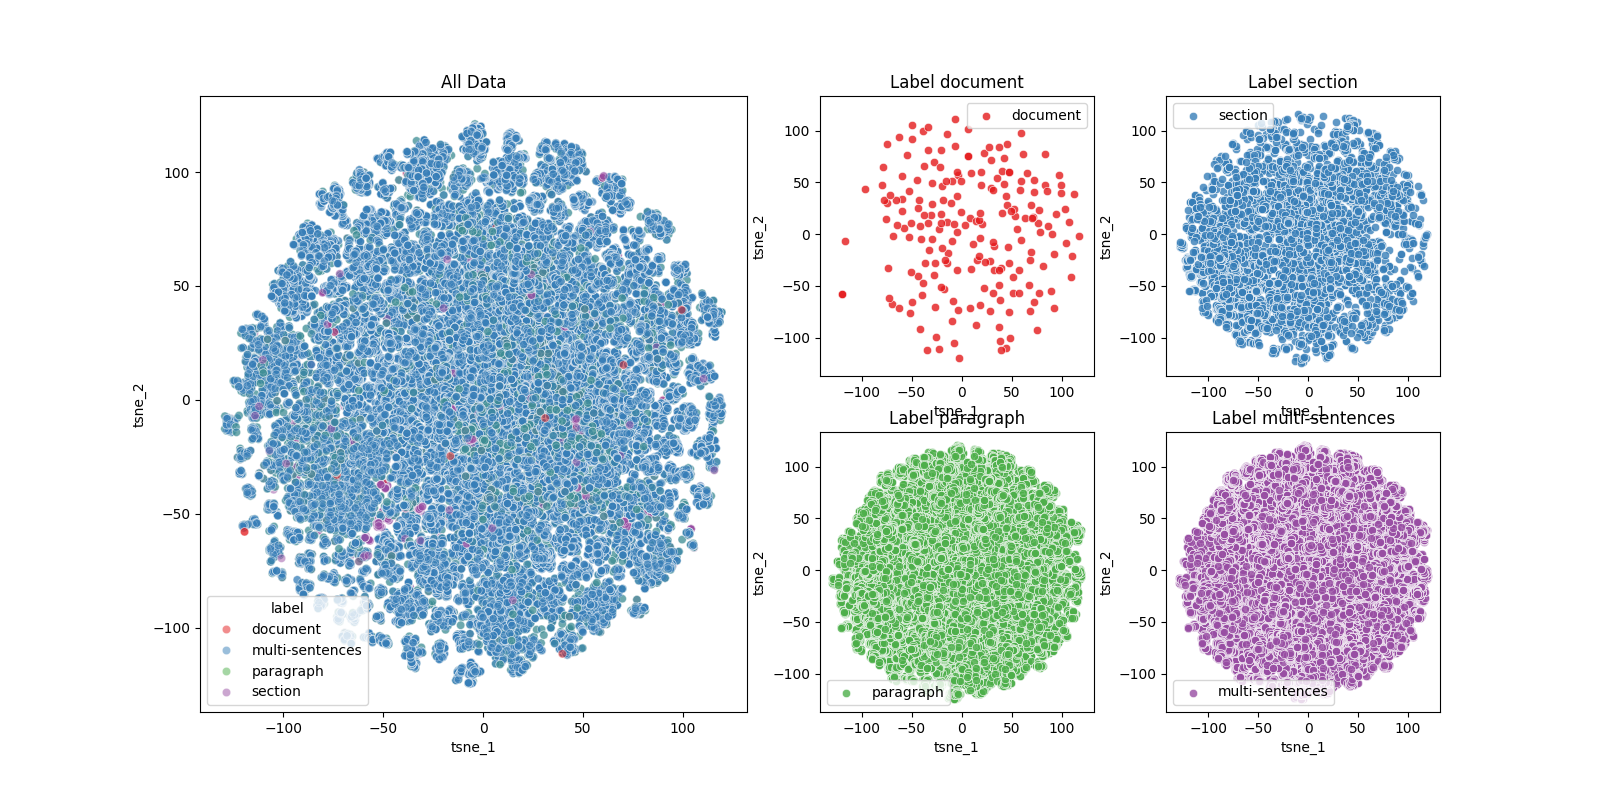

NameError: name 'nodes_file_name' is not defined

In [62]:
# Create a DataFrame with TSNE result and labels
tsne_result_df = create_tsne_dataframe(filtered_df[['tsne_x', 'tsne_y']].to_numpy(), filtered_df['level'])

# Define unique labels and color palette
unique_labels = tsne_result_df['label'].unique()
palette = sns.color_palette('Set1', len(unique_labels))

# Plot and save the TSNE result
plot_tsne_result(tsne_result_df, unique_labels, palette, "tsne_2367")

### TSNE - queries

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib.gridspec import GridSpec

# ------------------ Data Loading Functions ------------------

def load_jsonl(file_path):
    embeddings = []
    levels = []
    with open(file_path, 'r') as f:
        for line in f:
            # Parse each line as JSON and append it to the list
            obj = json.loads(line)
            embeddings.append(obj['embedding'])
            levels.append(obj['level'])
    return np.array(embeddings), levels

# ------------------ TSNE and Data Preparation ------------------

def get_tsne_result(embeddings, n_components=2):
    """Generate TSNE result from embeddings."""
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(embeddings)
    return tsne_result

def create_tsne_dataframe(tsne_result, levels):
    """Create a DataFrame with TSNE result and corresponding labels."""
    return pd.DataFrame({'tsne_1': tsne_result[:, 0], 'tsne_2': tsne_result[:, 1], 'label': levels})

# ------------------ Plotting Functions ------------------

def plot_tsne_result(tsne_result_df, unique_labels, palette, nodes_file_name):
    """Plot TSNE result using a scatter plot with subplots for individual labels."""
    # Create a figure and a GridSpec layout
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(2, 3, width_ratios=[2, 1, 1])

    # Create the large plot on the left (spanning both rows)
    ax_main = fig.add_subplot(gs[:, 0])
    sns.scatterplot(data=tsne_result_df, x='tsne_1', y='tsne_2', hue='label', palette=palette, ax=ax_main, alpha=0.5)
    ax_main.set_title('All Data')

    # Get x and y axis limits from the main plot
    xlim = ax_main.get_xlim()
    ylim = ax_main.get_ylim()

    # Create the 2x2 grid on the right for individual label plots
    for i, label in enumerate(unique_labels[:4]):
        ax = fig.add_subplot(gs[i // 2, i % 2 + 1])
        label_data = tsne_result_df[tsne_result_df['label'] == label]
        sns.scatterplot(data=label_data, x='tsne_1', y='tsne_2', color=palette[i], ax=ax, alpha=0.8)

        # Set x and y limits to match the main plot
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_title(f'Label {label}')
        ax.legend([label])

    # Adjust layout and save the image
    plt.tight_layout()
    plt.savefig(f"tsne_result_{nodes_file_name}.png")
    plt.close()

In [2]:
pid_num = 1
# Load embeddings
embeddings_file_path = f"../1_get_embedding_value/data/embeddings_question_pid_{pid_num}.jsonl"
embeddings, levels = load_jsonl(embeddings_file_path)

# Generate TSNE result
tsne_result = get_tsne_result(embeddings, 2)

In [5]:
# Create a DataFrame with TSNE result and labels
tsne_result_df = create_tsne_dataframe(tsne_result, levels)

# Define unique labels and color palette
unique_labels = tsne_result_df['label'].unique()
palette = sns.color_palette('Set1', len(unique_labels))

# Plot and save the TSNE result
plot_tsne_result(tsne_result_df, unique_labels, palette, embeddings_file_path.split('/')[-1].split('.')[0])

### Load data

In [24]:
import pandas as pd


In [25]:
# Load CSV file into DataFrame
df_pca = pd.read_hdf("cluster_result_pca.h5")

In [3]:
df_ae = pd.read_hdf("cluster_result_ae.h5")

In [30]:
df_kmeans = pd.read_hdf("cluster_result_kmeans.h5")

In [ ]:
import os, sys
sys.path.insert(0, os.path.abspath('.'))
from custom.io import load_nodes_jsonl

def load_nodes(pid_num, cache_dir):
    print("Loading nodes")
    file_name = f"gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_200_pid_{pid_num}.jsonl"
    file_path = os.path.join(cache_dir, file_name)
    nodes = load_nodes_jsonl(file_path)
    return nodes

nodes = load_nodes(1, os.path.abspath('./.save'))

### PCA

In [ ]:
df_pca

In [ ]:
import os, sys
sys.path.insert(0, os.path.abspath('.'))
from custom.io import load_nodes_jsonl

def load_nodes(pid_num, cache_dir):
    print("Loading nodes")
    file_name = f"gpt-4o-batch-all-p_2_parser_ManuallyHierarchicalNodeParser_8165_gpu_V100_nodeNum_200_pid_{pid_num}.jsonl"
    file_path = os.path.join(cache_dir, file_name)
    nodes = load_nodes_jsonl(file_path)
    return nodes

nodes = load_nodes(1, os.path.abspath('./.save'))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_kmeans['kmean_labels'], cmap='viridis', s = 50, alpha=0.5) 

# Create the scatter plot
# level2int = {level : i for i, level in enumerate(['document', 'section', 'paragraph', 'multi-sentences'])}
# scatter = plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=[level2int[node.metadata['level']] for node in nodes], cmap='viridis', s = 50, alpha=0.5) 
# Reverse the mapping for easy label creation
# int2level = {v: k for k, v in level2int.items()}

# Set the ticks to match the integer labels for the levels
# cbar = plt.colorbar(scatter, label='labels')
# cbar.set_ticks([0, 1, 2, 3])
# cbar.set_ticklabels(['document', 'section', 'paragraph', 'multi-sentences'])

# Create a legend using custom patches
# handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(level2int[level])), label=level) 
#            for level in level2int]
unique_labels = np.unique(df_kmeans['kmean_labels'])
# handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(level2int[level])), label=level) 
#            for level in level2int]
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(label)), label=f'Label {label}') for label in unique_labels]

# Add the legend to the plot (in the upper right corner)
plt.legend(handles=handles, title="Labels", loc='upper right')


# Add labels to the points
# for i, node in enumerate(nodes):
#     label = node.metadata['level']  # Get the text label
#     plt.text(df_pca['PCA1'].iloc[i], df_pca['PCA2'].iloc[i], label, fontsize=8, ha='right', color='black')

# Add titles and labels
plt.title('PCA of Clustered Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### AutoEncoder

In [ ]:
df_ae

In [21]:
selected_node = [node.metadata['level'] in ['document', 'section', 'paragraph', 'multi-sentences'] for node in nodes]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plot the results
plt.figure(figsize=(10, 8))
# scatter = plt.scatter(df_ae['AE1'], df_ae['AE2'], c=df_kmeans['kmean_labels'], cmap='viridis', s=50)

# Create the scatter plot
level2int = {level : i for i, level in enumerate(['document', 'section', 'paragraph', 'multi-sentences'])}
scatter = plt.scatter(df_ae['AE1'][selected_node], df_ae['AE2'][selected_node], c=[level2int[node.metadata['level']] for i, node in enumerate(nodes) if selected_node[i]], cmap='viridis', s = 50, alpha=0.5) 
# Reverse the mapping for easy label creation
int2level = {v: k for k, v in level2int.items()}

# Create a legend using custom patches
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(level2int[level])), label=level) 
           for level in level2int]

# Add the legend to the plot (in the upper right corner)
plt.legend(handles=handles, title="Labels", loc='upper right')

plt.title('AutoEncoder of Clustered Embeddings')
plt.xlabel('AutoEncoder Component 1')
plt.ylabel('AutoEncoder Component 2')
plt.show()

# Plot the results
plt.figure(figsize=(10, 8))
# scatter = plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_kmeans['kmean_labels'], cmap='viridis', s = 50, alpha=0.5) 


# Set the ticks to match the integer labels for the levels
# cbar = plt.colorbar(scatter, label='labels')
# cbar.set_ticks([0, 1, 2, 3])
# cbar.set_ticklabels(['document', 'section', 'paragraph', 'multi-sentences'])
